# Quantum control via commutative pop optimization

In [10]:
import matplotlib.pyplot as plt

import numpy as np

import pickle

from qutip import propagator, Qobj, Options

from qcontrol_polyopt import CQCPolyOptDyson, CQCPolyOptMagnus

from sympy import I, diag, Float, symbols, lambdify, sympify, Matrix

from sympy.matrices import randMatrix, matrix2numpy

# Constructing a quantum system

In [2]:
# Quantum system is taken from https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

# Drift Hamiltonian 
H0 = np.array([[0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 3.21505101e+10+0.j, 0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 0.00000000e+00+0.j, 6.23173079e+10+0.j]])

# Normalize the drift Hamiltonian by its maximum.
# This normalization factor can be accounted for by rescaling the time.
H0 /= H0.max()


# Control Hamiltonian
V = np.array([[0.        +0.j, 1.        +0.j, 0.        +0.j],
       [1.        +0.j, 0.        +0.j, 1.41421356+0.j],
       [0.        +0.j, 1.41421356+0.j, 0.        +0.j]])

# Normalize the control Hamiltonian by its maximum.
# This normalization factor can be accounted for by rescaling the control field.
V /= V.max()


Generate a quantum system with the hamiltonian
$\hat{H}(t) = \hat{H}_0 + u(t) \hat{V}$,
where $u(t)$ is a control field.

In [3]:
qsys_params = dict(
    
    H0 = Matrix(H0),
    V = Matrix(V),
    
    # final time
    T = 1, 
    
    # polynomial order for the control
    npoly=2,
    
    min_module='both',
    #min_module='scipy',
    #min_module='ncpol2sdpa',
)

# convert sympy matrix to qutip objects for subsequent propagation 
H0 = Qobj(matrix2numpy(qsys_params['H0']))
V = Qobj(matrix2numpy(qsys_params['V']))

# Perform calculations

In [4]:
amplitudes = [0]#[0.1, 0.5, 2, 10,]

fidelity_dyson_scipy = []
fidelity_dyson_ncpol2sdpa = []

fidelity_magnus_scipy = []
fidelity_magnus_ncpol2sdpa = []


for ampl in amplitudes:
    # the chosen control
    u_original_str = '0.1 + {} * sin(2 * 3.1416 * 1 * t)'.format(ampl)

    # get target unitary
    U_target = propagator(
        [H0, [V, u_original_str]], 
        qsys_params['T'],
    )

    # covert the chosen control to the numpy function for plotting
    #t = symbols('t')
    #u_original = lambdify(t, sympify(u_original_str), 'numpy')
    
    dyson_result = CQCPolyOptDyson(U_target=U_target, **qsys_params)
    
    U_dyson = propagator([H0, [V, dyson_result.u_reconstructed['scipy'][0]]], dyson_result.T)
    fidelity_dyson_scipy.append(
        (U_dyson - U_target).norm()
    )
    print(fidelity_dyson_scipy[-1])
    
    U_dyson = propagator([H0, [V, dyson_result.u_reconstructed['ncpol2sdpa'][0]]], dyson_result.T)
    fidelity_dyson_ncpol2sdpa.append(
        (U_dyson - U_target).norm()
    )
    print(fidelity_dyson_ncpol2sdpa[-1])
    
    
    magnus_result = CQCPolyOptMagnus(U_target=U_target, **qsys_params)
    U_magnus = propagator([H0, [V, magnus_result.u_reconstructed['scipy'][0]]], magnus_result.T)
    fidelity_magnus_scipy.append(
        (U_magnus - U_target).norm()
    )
    print(fidelity_magnus_scipy[-1])
    
    U_magnus = propagator([H0, [V, magnus_result.u_reconstructed['ncpol2sdpa'][0]]], magnus_result.T)
    fidelity_magnus_ncpol2sdpa.append(
        (U_magnus - U_target).norm()
    )
    print(fidelity_magnus_ncpol2sdpa[-1])
    
    print(ampl)
    print("============================================================")
    
    
    

<function _lambdifygenerated at 0x7faa3e4b69d0>
t1*x1 + x0


/Users/dbondar/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method CG does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


0.0005980748499892108
0.0005979825272418312
0.11234871007948737
0.11234866338867493
0


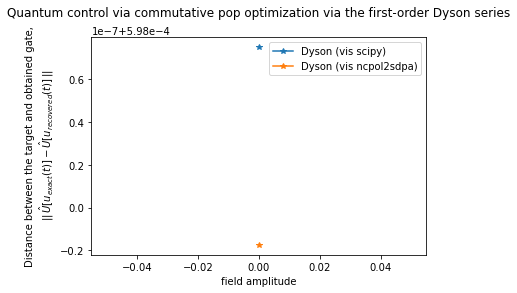

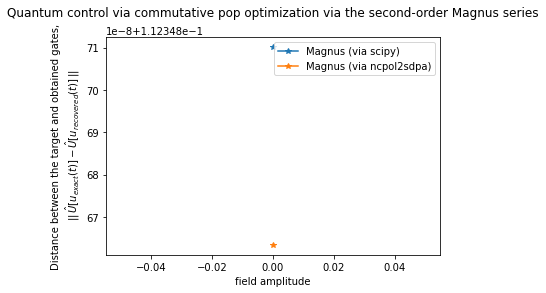

In [5]:
plt.title("Quantum control via commutative pop optimization via the first-order Dyson series\n")

plt.plot(amplitudes, fidelity_dyson_scipy, '*-', label='Dyson (vis scipy)')
plt.plot(amplitudes, fidelity_dyson_ncpol2sdpa, '*-', label='Dyson (vis ncpol2sdpa)')
plt.xlabel('field amplitude')
plt.ylabel('Distance between the target and obtained gate,\n $||\, \hat{U}[u_{exact}(t)] - \hat{U}[u_{recovered}(t)] \,||$')
plt.legend()
plt.show()

plt.title("Quantum control via commutative pop optimization via the second-order Magnus series\n")
plt.plot(amplitudes, fidelity_magnus_scipy, '*-', label='Magnus (via scipy)')
plt.plot(amplitudes, fidelity_magnus_ncpol2sdpa, '*-', label='Magnus (via ncpol2sdpa)')

plt.xlabel('field amplitude')
plt.ylabel('Distance between the target and obtained gates,\n $||\, \hat{U}[u_{exact}(t)] - \hat{U}[u_{recovered}(t)] \,||$')
plt.legend()
plt.show()

In [6]:
t = symbols('t')
u_original = lambdify(t, sympify(u_original_str), 'numpy')
    
times = np.linspace(0, qsys_params['T'], 200)

u_scipy = magnus_result.u_reconstructed['scipy'][1]

u_ncpol2sdpa = magnus_result.u_reconstructed['ncpol2sdpa'][1]

In [7]:
sympify(u_original_str)

0.100000000000000

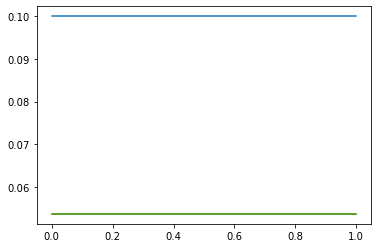

In [8]:
plt.plot(times, u_original(times) + 0 * times)
plt.plot(times, u_scipy(times))
plt.plot(times, u_ncpol2sdpa(times))

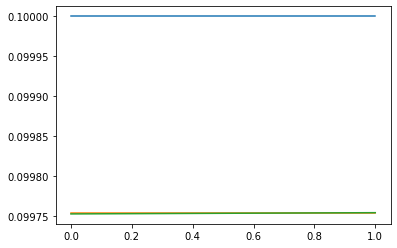

In [9]:
u_scipy = dyson_result.u_reconstructed['scipy'][1]

u_ncpol2sdpa = dyson_result.u_reconstructed['ncpol2sdpa'][1]

plt.plot(times, u_original(times) + 0 * times)
plt.plot(times, u_scipy(times))
plt.plot(times, u_ncpol2sdpa(times))